# ANALYSIS OF RESULTS

This section focuses on analyzing the performance of the tested models and identifying the weak points of each approach.

**Workflow for this module:**

1.  **Confusion Matrix Analysis**: Evaluation of prediction accuracy across different stages.
2.  **FNR and FPR Analysis**: Assessment of False Negative and False Positive rates.
3.  **Severely Misclassified Sample Analysis**: Investigation of specific outlier cases.
4.  **Conclusion**: Final summary and comparison of the models.

In [1]:
import joblib
from sklearn.metrics import matthews_corrcoef , confusion_matrix, classification_report,roc_curve, auc
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import sys
import os
module_path = os.path.abspath(os.path.join('..', 'codes'))
if module_path not in sys.path:
    sys.path.append(module_path)
from confusion_matrix import plot_cm
from fpr_fnr import plot_fn_rate, plot_fp_rate

In [2]:
df=pd.read_csv("../data/data_refined_stratifkfold.csv")
df.set_index('ID', inplace=True) #let's set ID column like index. so we will don't have problem with that during analysis.
x_bench,y_bench=df.query("Set=='Benchmark'").drop(columns=['Set','Stage']),df.query("Set=='Benchmark'")['Stage']
bench_pred_tree = joblib.load('../data/benchmark_prediction_tree.pkl')
bench_pred_svm = joblib.load('../data/benchmark_prediction_svm.pkl')
bench_pred_lr = joblib.load('../data/benchmark_prediction_lr.pkl')
with open('../models/tree_model.pkl', 'rb') as f:
    loaded_tree = pickle.load(f)
with open('../models/lr_model.pkl', 'rb') as f:
    loaded_lr = pickle.load(f)
with open('../models/svm_model.pkl', 'rb') as f:
    loaded_svm = pickle.load(f) # Ci serve per la ROC
features_tree = joblib.load('../data/best_features_list_tree.pkl')
features_lr = joblib.load('../data/best_features_list_lr.pkl')
features_svm = joblib.load('../data/best_features_list_svm.pkl') # Se serve
x_bench_tree = x_bench[features_tree]
x_bench_lr = x_bench[features_lr]
x_bench_svm = x_bench[features_svm]
x_trainval,y_trainval=df.query("Set=='1' or Set=='2' or Set=='3' or Set=='4' or Set=='5'").drop(columns=['Set','Stage']),df.query("Set=='1' or Set=='2' or Set=='3' or Set=='4' or Set=='5'")['Stage']

## 1. Confusion Matrix Analysis

In [3]:

# complete report performances benchmark tree
print("\n--- Classification Report tree  ---")
print(classification_report(y_bench, bench_pred_tree))
print("MCC  ", matthews_corrcoef(y_bench,bench_pred_tree))



# Complete report performances benchmark svm
print("\n--- Classification Report svm  ---")
print(classification_report(y_bench, bench_pred_svm))
print("MCC  ",matthews_corrcoef(y_bench,bench_pred_svm))






# complete report performances benchmark  logistic regression
print("\n--- Classification Report lr ---")
print(classification_report(y_bench, bench_pred_lr))
print("MCC  ",matthews_corrcoef(y_bench,bench_pred_lr))



--- Classification Report tree  ---
              precision    recall  f1-score   support

         1.0       0.12      0.33      0.18         3
         2.0       0.31      0.36      0.33        14
         3.0       0.53      0.38      0.44        24
         4.0       0.68      0.68      0.68        22

    accuracy                           0.48        63
   macro avg       0.41      0.44      0.41        63
weighted avg       0.52      0.48      0.49        63

MCC   0.26894500263036114

--- Classification Report svm  ---
              precision    recall  f1-score   support

         1.0       0.11      0.33      0.17         3
         2.0       0.41      0.50      0.45        14
         3.0       0.53      0.33      0.41        24
         4.0       0.68      0.68      0.68        22

    accuracy                           0.49        63
   macro avg       0.43      0.46      0.43        63
weighted avg       0.54      0.49      0.50        63

MCC   0.30191881732829323

--- 

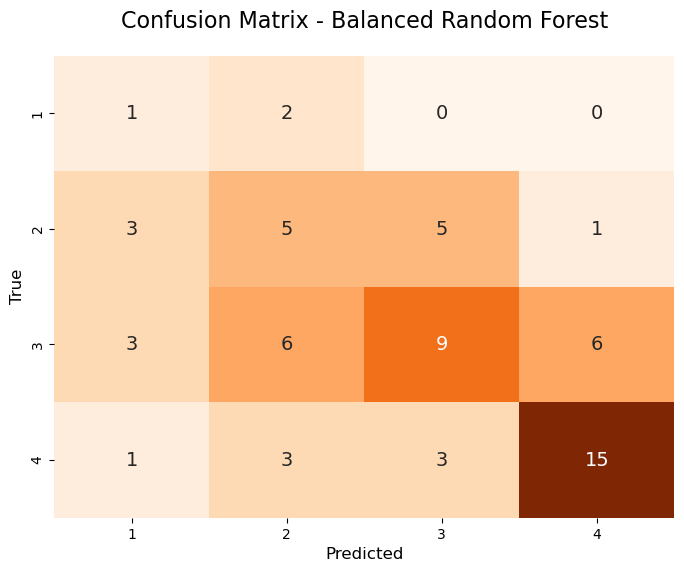

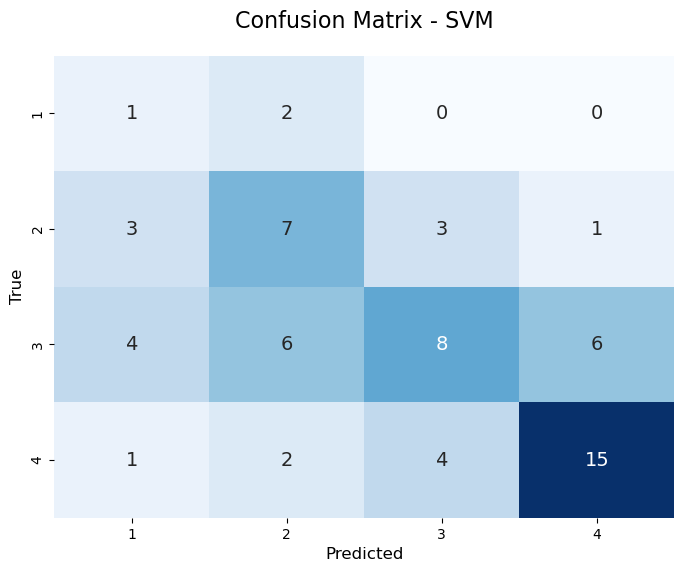

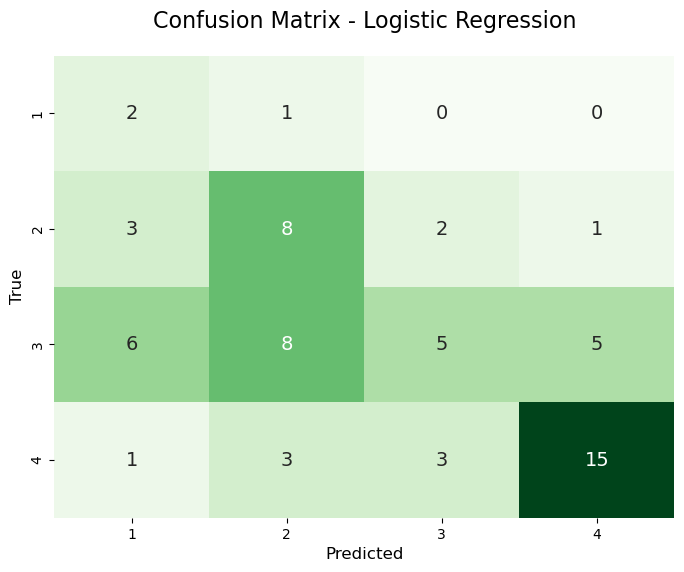

In [4]:
plot_cm(y_bench,bench_pred_tree,'Balanced Random Forest', 'Oranges','../figures/04_cm_tree.svg')
plot_cm(y_bench,bench_pred_svm,'SVM','Blues','../figures/04_cm_svm.svg')
plot_cm(y_bench,bench_pred_lr,'Logistic Regression', 'Greens', '../figures/04_cm_lr.svg')


The confusion matrices provide a granular view of the models' misclassification patterns, revealing strengths and weaknesses that aggregate metrics might obscure.

First of all the models showed a robust prediction of the Stage 4 patients.  Starting our analysis on the confusion matrix of the balanced random forest, we can see how he was also relatively sufficiently good for Stage 3, but it was very bad in Stage 2 and 1 prediction. 

The SVM model indeed was a pretty decent classificator model beside stage 1 were also him showed very bad prediction.

Finally, Logistic Regfression showed the most stage 1 robust classification detecting 2 of 3 Stage 1 patients. It also showed a very good classification for Stage 4, and pretty decent for Stage 2. But it was very weak for Stage 3, where the other models showed a discrete performance. 

It is important also to evidence that all the three models did a severly wrong prediction, (Stage 4 predicted like Stage 1). It could be useful analyze if that patient was the same, and why both models wrong.

## 2. FNR and FPR Analysis

Let's see better the distribution of False Negatives across the stages

In [5]:
benchmark=x_bench.copy()
benchmark['Stage']=y_bench
prediction_columns=['Tree_Prediction','SVM_Prediction', 'LR_Prediction']
benchmark[prediction_columns[0]]=bench_pred_tree
benchmark[prediction_columns[1]]=bench_pred_svm
benchmark[prediction_columns[2]]=bench_pred_lr
colors = ["#d6873c", "#9cb8d7","#87ba76"]
customPalette = sns.set_palette(sns.color_palette(colors))
real_columns='Stage'

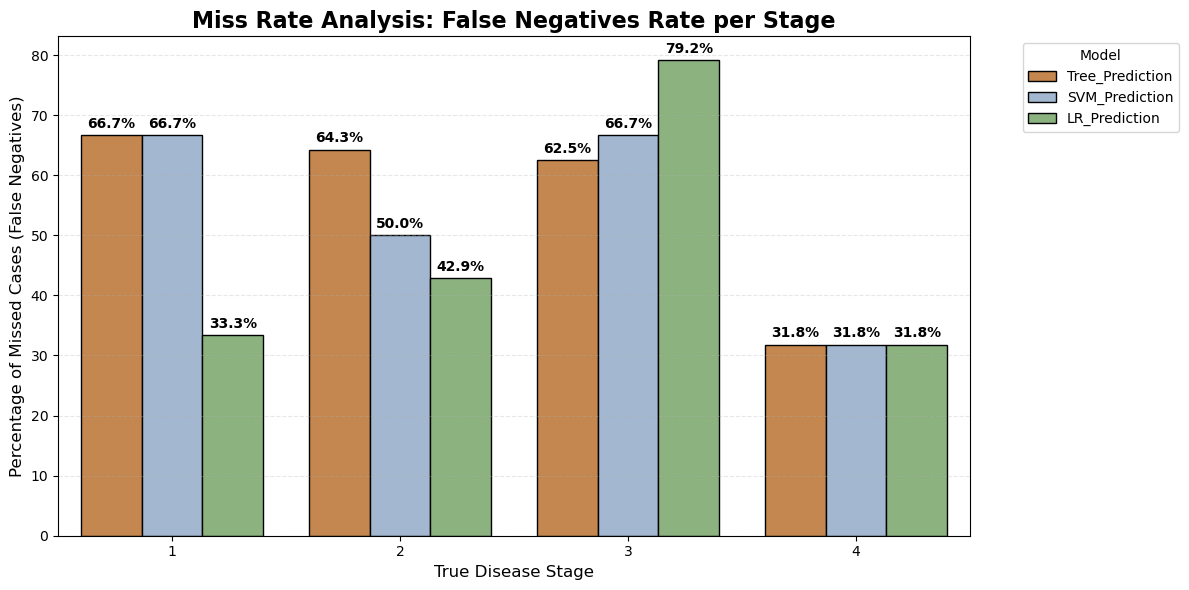

In [6]:
fig=plot_fn_rate(benchmark, real_columns,prediction_columns,'Miss Rate Analysis: False Negatives Rate per Stage', customPalette)
fig.savefig('../figures/04_fnr.svg')
fig.show()

The Miss Rate analysis (False Negative Rate) provides another critical insights into the limitations and behavioral differences of the three models. Like anticipated Logistic Regression (LR) , achieved the lowest false negative rates across Stages 1, and 2. However, it exhibited a significant spike in error rate for Stage 3 (79.2%). This anomaly,  with its relatively strong performance in Stage 2 (42.9%), suggests (and we can see this also in the confusion matrix) a bias in the linear decision boundary: the model tends to misclassify Stage 3 patients as Stage 2 (the adjacent lower class), effectively prioritizing the detection of the earlier stage at the expense of the third one. 

The BRF (Tree) displayed indeed a similar FNR between Stage 3, 2 and 1. While for Stage 1 is diffult to say if the reason is for the poor size of samples, for Stage 2 and 3 we can say that BRF struggled to recognize mid-stage disease.  

The SVM presented a hybrid behavior between LR and Balanced Random Forest resulting in the more balanced model for mid-stage: it is more robust to predict Stage 2 than BRF and Stage 3 than LR.However it has the same inability  to detect  Stage 1 patients, preventing the algorithm from establishing valid support vectors for this minority class.

From a clinical perspective, the most encouraging result is that Stage 4 (Cirrhosis) consistently showed the lowest False Negative Rates across all models (curiosly all three models performed with the same FNR: 31.8%). This confirms that the biological signal for decompensated cirrhosis is the most distinct and recognizable. While minimizing missed diagnoses in the most severe stage is crucial for patient safety, the absolute error rates remain too high for clinical deployment. This indicates that despite the distinct biological signal of late stage disease, the current dataset size is likely insufficient to allow classic Machine Learning models to generalize effectively across the entire disease spectrum.

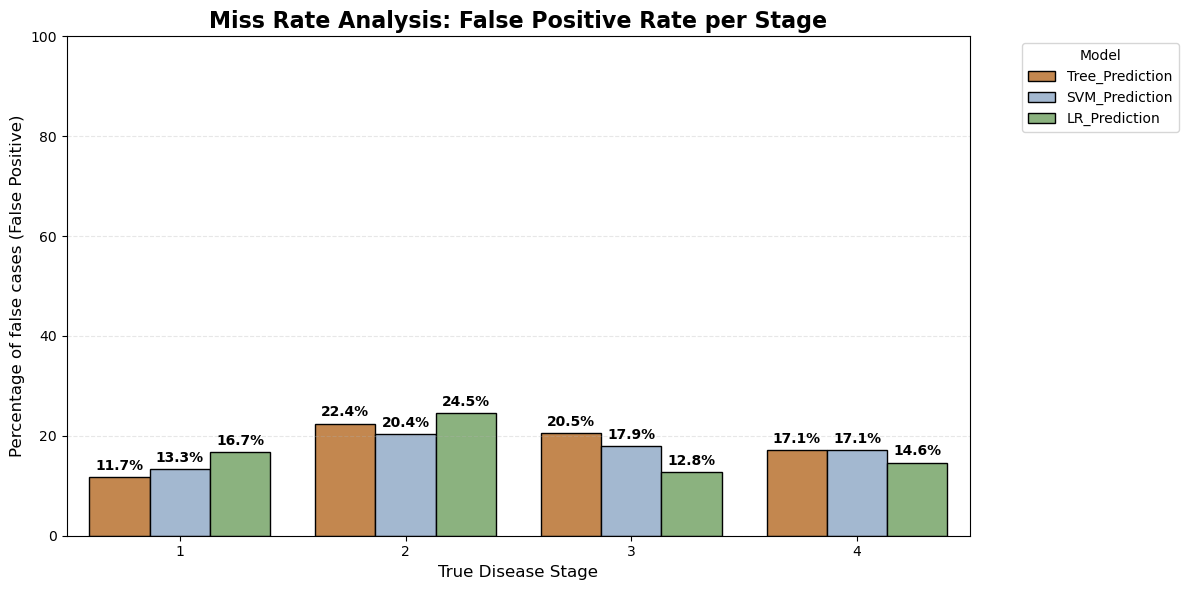

In [7]:
fig=plot_fp_rate(benchmark, real_columns,prediction_columns,'Miss Rate Analysis: False Positive Rate per Stage',customPalette)
fig.savefig('../figures/04_fpr.svg')
fig.show()

The analysis of the False Positive Rate reveals that the model does not exhibit a significant bias towards any specific class. In other words, misclassified patients are not systematically assigned to a single stage, but rather the errors appear to be distributed. 

## 3. Severely Misclassified Sample Analysis

Now is  useful to understand see if the Stage 4 patients missclassified as Stage 1 is the same between SVM , LR  and BRF and why. This, clinically is the most critical case, because a Stage 4 classified like Class 1 could be deadily relevant for a patient.

In [8]:
severely_missclassified=benchmark.query(f"(Stage==1 and ({prediction_columns[0]}==4 or {prediction_columns[1]}==4 or {prediction_columns[2]}==4)) or (Stage==4 and ({prediction_columns[0]}==1 or {prediction_columns[1]}==1 or {prediction_columns[2]}==1))")

In [9]:
severely_missclassified

,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Tree_Prediction,SVM_Prediction,LR_Prediction
ID,,,,,,,,,,,,,,,,,,,,
275,0,-1.107768,0,0,0,0,0,-0.233491,0.916029,0.596348,-0.246882,0.251453,-0.539783,-0.172259,0.495224,-1.222326,4.0,1.0,1.0,1.0


It is interesting to see that also if there are some false positive in Stage 4, non of them is from Stage 1 (you can see that also from confusion matrix). This does not proves at 100% that the model can effectively recognize from stage 1 and 4, because the number of Stage 1 samples in benchmark is very very poor, but if we evaluate this thing with the fact that there is only one cases that is Stage 4 missclassified like Stage 1, we can say that the model in some way can distinguish relatively well the difference between stage 1 and 4. 
Now let's see why this patient was classified like Stage 1 by LR and SVM. To do this could be useful to overlap his values to the values of Stage 1-4 patients in the feature distribution of benchmark , to check eventually similarities. To understand clinically better what is happened is better to visualize feature distribution unscaled.

In [10]:
original_dataset=pd.read_csv("../data/cirrhosis.csv", index_col='ID')

In [11]:
original_dataset.query("Stage=='1' or Stage=='4'")
benchmark_unscaled = original_dataset.query("Stage==1 or Stage==4").loc[benchmark.query("Stage==1 or Stage==4").index].copy()
severely_missclassified_unscaled = original_dataset.loc[severely_missclassified.index].copy()

In [12]:
severely_missclassified_unscaled

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
275,1349,C,D-penicillamine,13995,F,N,N,N,N,2.2,572.0,3.77,77.0,2520.0,92.0,114.0,309.0,9.5,4.0


now let's check which features svm and Lr used, to see if there are commons features between the two models, and  to be sure that we'll analyze all these features.

In [13]:
print("Logistic Regression used the following features: ",features_lr)
print("SVM used the following features: ",features_svm)
common_features=[]
uncommon_features=[]
for i in features_lr:
    if i in features_svm:
        common_features.append(i)
    else:
        uncommon_features.append(i)
print("Common features between the two models are: ",common_features)
print("Uncommon features are: ", uncommon_features)

Logistic Regression used the following features:  ['Age', 'Hepatomegaly', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
SVM used the following features:  ['Age', 'Hepatomegaly', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
Common features between the two models are:  ['Age', 'Hepatomegaly', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
Uncommon features are:  []


The feature are exactly the same so we can focalize on all these feature to analyze why all the three models missclassified this stage 4 like a Stage 1 prediction. We have to exclude Hepatomegaly because is a categorical feature and we will analyze it in a separate way.

In [14]:
common_features.remove('Hepatomegaly')

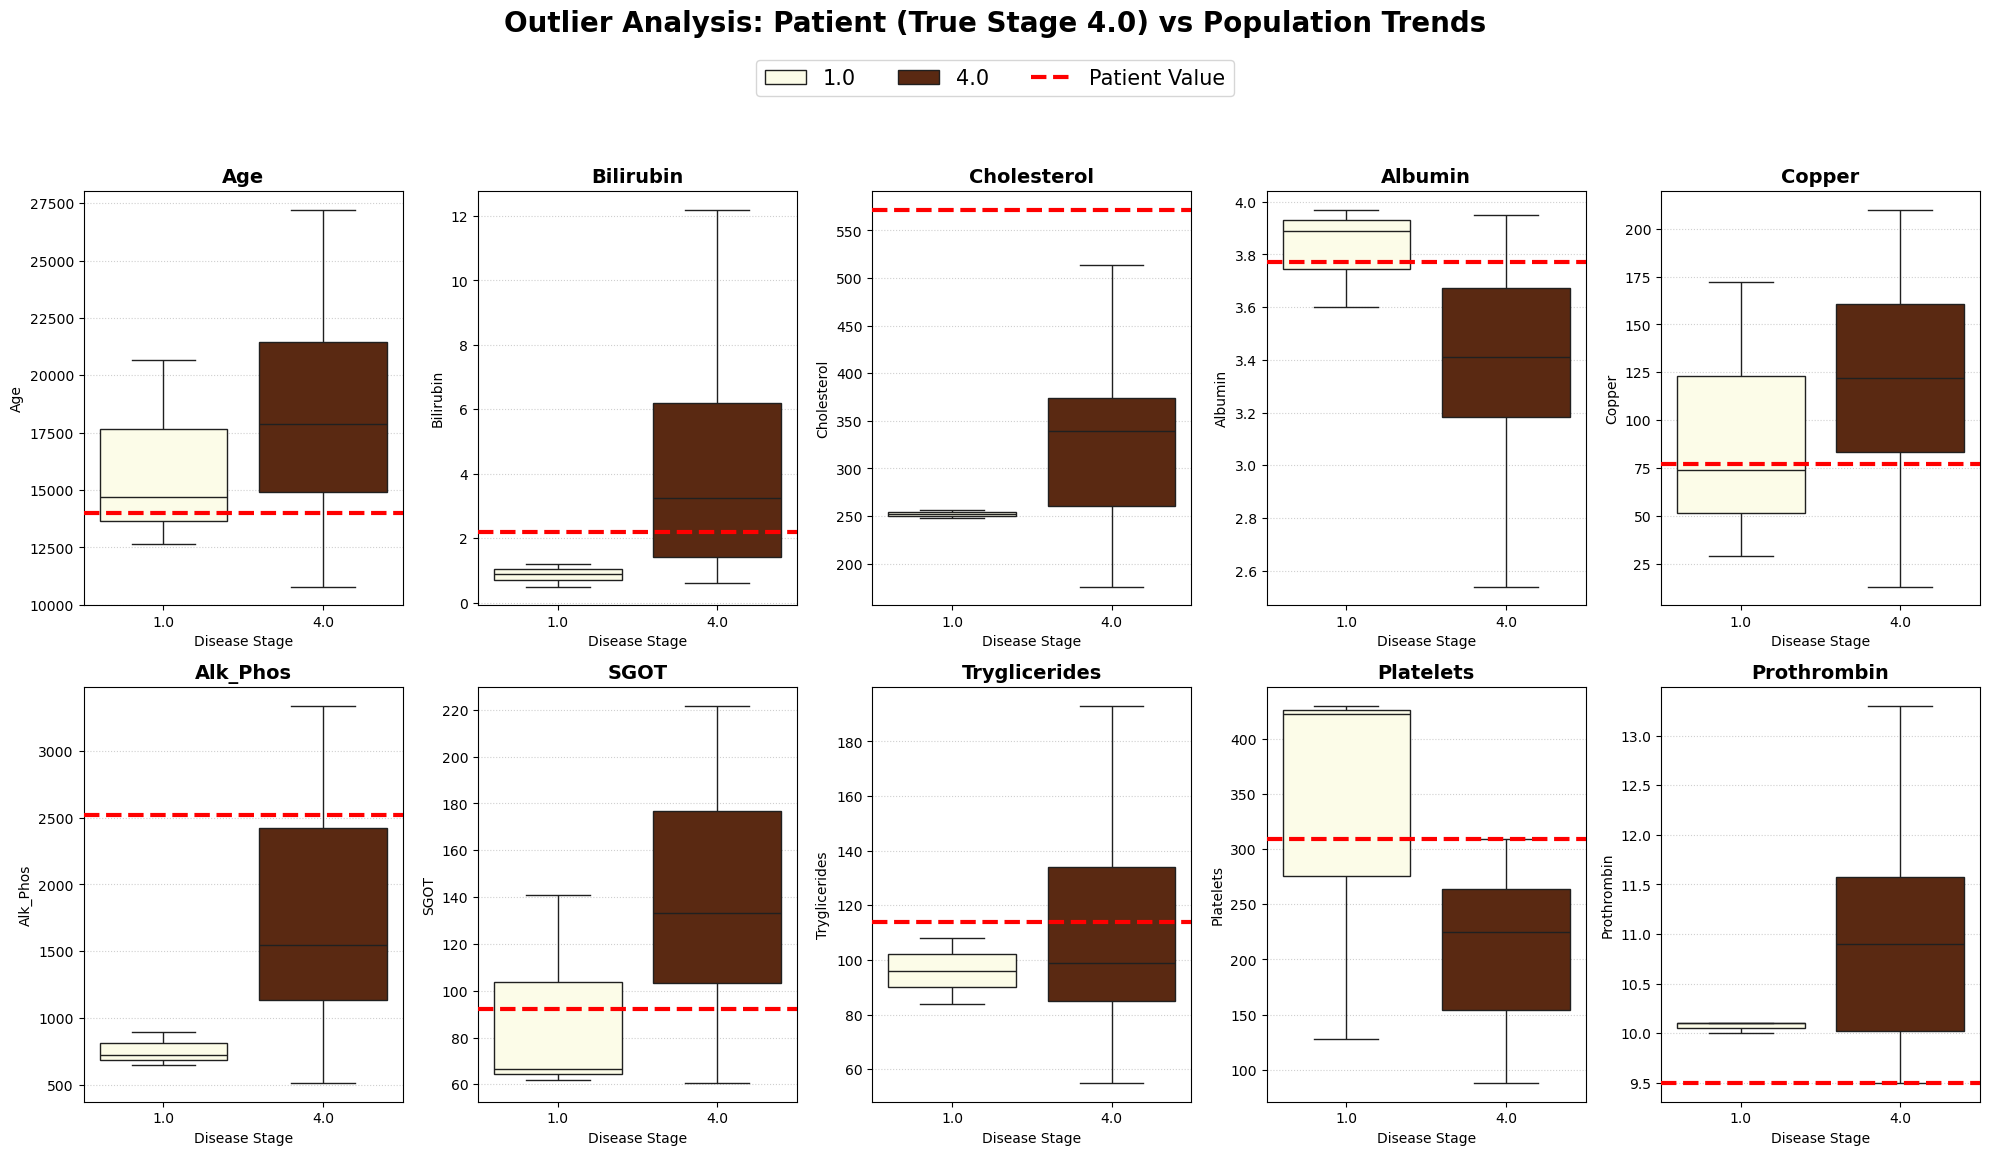

In [15]:
feature_names=common_features
n_cols = 5
n_rows = (len(feature_names) // 3) + (1 if len(feature_names) % 3 > 0 else 0)

# Recuperiamo lo stadio reale per il titolo (assumendo che outlier_row sia un DataFrame)
true_stage = severely_missclassified_unscaled['Stage'].values[0]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

fig.suptitle(f"Outlier Analysis: Patient (True Stage {true_stage}) vs Population Trends", 
             fontsize=20, weight='bold', y=1.05)

legend_added = False # Serve per non ripetere la label della linea rossa in ogni leggenda

for i, feature in enumerate(feature_names):
    ax = axes[i]
    
    # 1. BOXPLOT: La distribuzione della popolazione
    sns.boxplot(x='Stage', y=feature, data=benchmark_unscaled, ax=ax, hue='Stage', palette='YlOrBr', showfliers=False)
    
    # 2. LINEA ROSSA: Il valore del paziente
    # Estraiamo il valore scalare
    patient_value = severely_missclassified_unscaled[feature].values[0]
    
    # axhline disegna una linea su tutto l'asse X (da 0 a 1 in coordinate relative)
    ax.axhline(
        y=patient_value, 
        color='red', 
        linewidth=3, 
        linestyle='--',   # Tratteggiata come chiedevi (o '-' per solida)
        label='Patient Value',
        zorder=10         # Assicura che sia sopra i boxplot
    )
    
    if not legend_added: legend_added = True
    
    ax.set_title(f"{feature}", fontsize=14, weight='bold')
    ax.set_xlabel("Disease Stage")
    ax.set_ylabel(f"{feature}")
    ax.grid(axis='y', linestyle=':', alpha=0.6)
    ax.get_legend().remove() # remove individual legends to make possible print only one legend for all the graphs.
# Rimuoviamo assi vuoti in eccesso
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Legenda unica globale
handles, labels = axes[0].get_legend_handles_labels()
# Aggiungiamo manualmente la linea rossa se seaborn non l'ha presa (a volte capita coi boxplot misti)
if "Patient Value" not in labels:
    from matplotlib.lines import Line2D
    custom_line = Line2D([0], [0], color='red', linewidth=3, linestyle='--')
    handles.append(custom_line)
    labels.append("Patient Value")
    
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3, fontsize=15)
plt.tight_layout()
fig.savefig('../figures/04_severly_missclass_numerical_features.svg')
plt.show()

Several factors probably contributed to this misclassification. As shown in the distribution plots, the patient's biochemical profile appeared unusually 'healthy' for a Stage 4 case. Specifically, Albumin levels (gm/dl) were unexpectedly high compared to the Stage 4 median, while Copper levels (ug/day) were notably lower. Similarly, SGOT levels (U/ml) were anomalously low, and Platelet counts (ml/1000) were higher than typically observed in cirrhotic patients. Finally, the Prothrombin values were also very  strangely low (could be a bias in the measurement). 

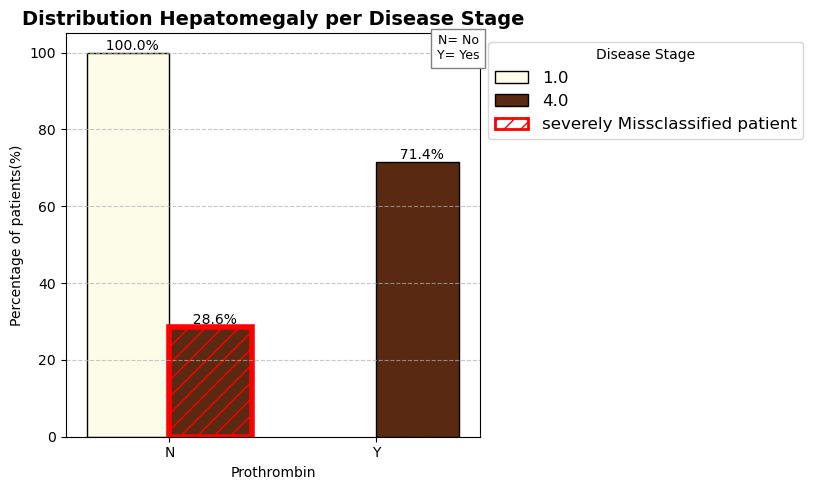

In [16]:
features_to_plot='Hepatomegaly'
n_cols = 1
n_rows = len(features_to_plot)
glossary = {
    'Ascites': "N = No\nY = Yes",
    'Hepatomegaly': "N= No\nY= Yes",
    'Spiders': "N= No\nY= Yes",
    'Edema': "N= No edema & no diuretics\nS= Edema (no diuretics/resolved)\nY= Edema despite diuretics",
    'Status': "C= Censored\nCL= Censored (Liver Tx)\nD= Death",
    'Sex': "F= Female\nM= Male",
    'Drug': "D-pen= D-penicillamine\nP= Placebo"
}
stage_counts = benchmark_unscaled.dropna()['Stage'].value_counts().sort_index()
stage_labels = [f"{int(stage)}\n(n={count})" for stage, count in stage_counts.items()]
# initialize figure with dynamic height
plt.figure(figsize=(5, 5))
props = (benchmark_unscaled.dropna().groupby(['Stage'])[features_to_plot].value_counts(normalize=True).rename('percent').mul(100).reset_index())# calculate relative percentages within each stage to normalize class imbalance
fig=sns.barplot(x=features_to_plot, y='percent', hue='Stage', data=props, palette='YlOrBr', edgecolor='black')# plot bar chart representing percentages
for container in fig.containers:# add precise percentage labels on top of bars
        fig.bar_label(container, fontsize=10, fmt='  %.1f%%')
true_stage = severely_missclassified_unscaled['Stage'].values[0] # Es. 4.0
patient_val = str(severely_missclassified_unscaled[features_to_plot].values[0]) #let's find the value of the patient (if have or not hepatomegaly)
sorted_stages = sorted(props['Stage'].unique()) 
stage_idx = sorted_stages.index(true_stage) 
target_container = fig.containers[stage_idx]

#let's find the position on the boxplot of the patient
x_categories = [t.get_text() for t in fig.get_xticklabels()]
val_idx = x_categories.index(patient_val)

#highlight that bar
target_bar = target_container[val_idx]
target_bar.set_edgecolor('red')     
target_bar.set_linewidth(4)         
target_bar.set_hatch('//')        
target_bar.set_alpha(1)             
plt.grid(axis = 'y', linestyle='--', alpha=0.7) #add horizontal grid lines
plt.title(f'Distribution {features_to_plot} per Disease Stage', fontsize=14, weight='bold')
plt.xlabel(feature)
plt.ylabel(f'Percentage of patients(%)')
#create and add an handmade legend that describe the meaning of the classes for each categorical feature. 
plt.text(0.998, 0.998, glossary[features_to_plot], 
        transform=fig.transAxes,  
        ha='right', va='top',    
        fontsize=9,
        bbox=dict(fc="white", ec="gray", alpha=1)) 

handles, labels = fig.get_legend_handles_labels()
red_patch = Patch(facecolor='none', edgecolor='red', hatch='//', linewidth=2, label='YOU (Patient Group)')
handles.append(red_patch) # Aggiungiamo alla lista
labels.append('severely Missclassified patient')
plt.tight_layout()
fig.legend(handles, labels, ncol=1, title='Disease Stage', fontsize=12, bbox_to_anchor=(1,1))
plt.savefig('../figures/04_severly_missclass_categorical_features.svg', bbox_inches='tight')
plt.show()

Another feature that could lead confusion to the models was Hepatomegaly... This categorical feature shows if a patient has hepatomegaly or not. How we can see this patient is the part of a small group of patients that despite being Stage 4, does not suffer from Hepatomegaly.

## 4. Conclusions

In conclusion, the models generally did not perform well in accurately classifying patients into their respective stages. However, they showed fair capability in distinguishing between Stage 1 and Stage 4. The performance issues may be attributed to the scarcity of cases, particularly for Stage 1, which hindered effective training and robust testing. In addition, it is important to consider that a significant percentage of the data was inferred using imputation methods. This strategy was necessary to avoid further data loss in an already limited dataset.
Ultimately, the Logistic Regression model proved to be the best approach for a more balanced classification. It outperformed the other two models, enabling robust classification not only for Stage 4 but also for Stage 2 and Stage 1, although the latter result must be interpreted with caution due to the extremely low sample size (only 3 cases).
Finally, the application of Deep Learning techniques, particularly for representation learning, could yield more satisfactory results on this dataset, potentially succeeding where the classical classification methods tested here fell short.